# Where of York Region should I open my new store?

## My Business Problem

## What to do?

I will utilize my data science skills to solve this problem.

## Plan

What I am going to do are -
1. Get GTA Data
2. Explore and Segment GTA
3. Cluster Neighborhoods GTA
4. Make the decision

The following are the more detailed steps -
1. Get the York Region neighborhood data from anywhere. I chose Wikipedia.
2. Join the Geocoder Python data to get the latitudes and longitudes.
3. Call Foursquare API to get the venues data.
4. Use k-means to cluster the data.
5. Analyze the cluster reports based on my criteria. 
6. Make the business decision.

## The Data

Let's get the data first.

## Get Toronto Data

### Part 1

First I will scrape the following Wikipedia page, https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M, in order to obtain the data that is in the table of postal codes and to transform the data into a pandas dataframe like the one shown below:


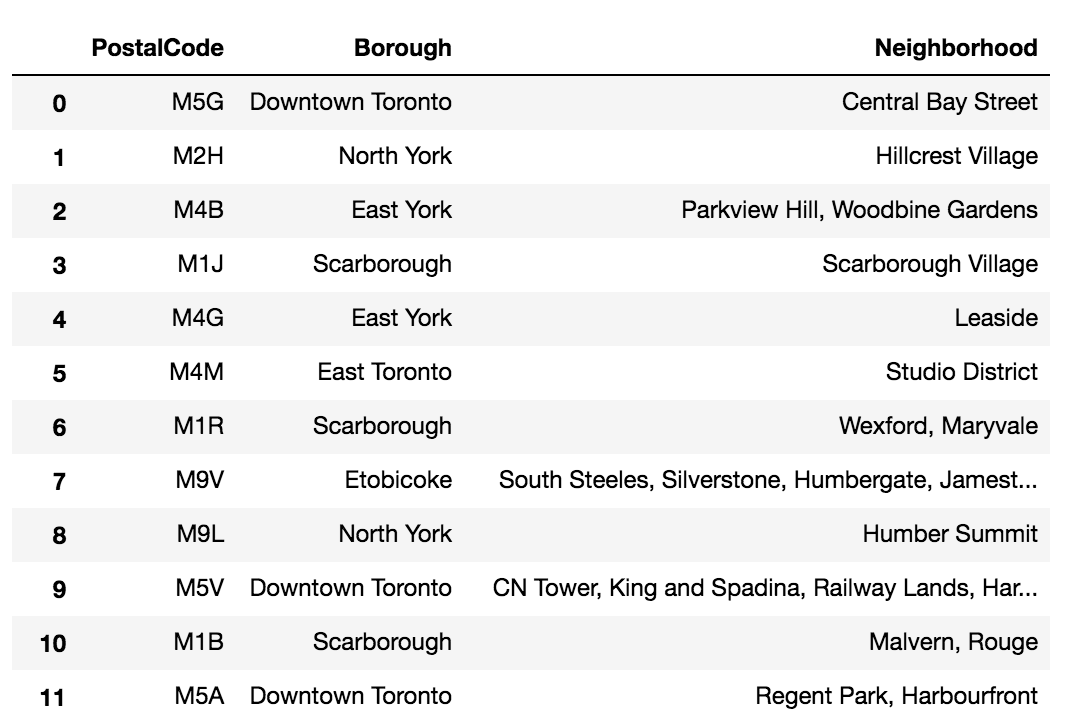

To create the above dataframe:
* The dataframe will consist of three columns: PostalCode, Borough, and Neighborhood
* Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
* More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.
* If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.


### Inspect HTML



The following is from the html source code of the Toronto FSA table.

<table class="wikitable sortable">
<tbody><tr>
<th>Postcode</th>
<th>Borough</th>
<th>Neighbourhood
</th></tr>
<tr>
<td>M1A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M2A</td>
<td>Not assigned</td>
<td>Not assigned
</td></tr>
<tr>
<td>M3A</td>
<td><a href="/wiki/North_York" title="North York">North York</a></td>
<td><a href="/wiki/Parkwoods" title="Parkwoods">Parkwoods</a>
</td></tr>
<tr>


### Import Libraries

Install the packages if needed

In [129]:
#!conda install -c conda-forge geopy --yes
#!conda install -c conda-forge folium=0.5.0 --yes
#!conda install -c conda-forge geocoder --yes

In [130]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import geocoder # import geocoder

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets.samples_generator import make_blobs

import folium # map rendering library

import lxml
import lxml.html as lh

#from bs4 import BeautifulSoup

print('Libraries imported.')

Libraries imported.


In [131]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'

#Create a handle, page, to handle the contents of the website
page = requests.get(url)

#Store the contents of the website under doc
doc = lh.fromstring(page.content)
#print(doc)

#Parse data that are stored between <tr>..</tr> of HTML
tr_elements = doc.xpath('//tr')

### Do the magics

For sanity check, ensure that all the rows have the same width. If not, we probably got something more than just the table.

In [132]:
#Check the length of the first 12 rows
[len(T) for T in tr_elements[:12]]

[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

Looks like all our rows have exactly 10 columns. This means all the data collected on tr_elements are from the table.

Next, let's parse the first row as our header.

In [133]:
tr_elements = doc.xpath('//tr')
#Create empty list
col=[]
i=0
#For each row, store each first element (header) and an empty list
for t in tr_elements[0]:
    i+=1
    #Neighbourhood\n -> Neighbourhood
    name=t.text_content().replace('\n', '')
    print ('%d : "%s"' % (i, name))
    col.append((name,[]))

1 : "Postcode"
2 : "Borough"
3 : "Neighbourhood"


Creating Pandas DataFrame

In [134]:
#Since out first row is the header, data is stored on the second row onwards
for j in range(1,len(tr_elements)):
    #T is our j'th row
    T=tr_elements[j]
    
    #If row is not of size 10, the //tr data is not from our table 
    if len(T)!=3:
        break
    
    #i is the index of our column
    i=0
    
    #Iterate through each element of the row
    for t in T.iterchildren():
        #Neighbourhood\n -> Neighbourhood
        data=t.text_content().replace('\n', '')
        #Check if row is empty
        if i>0:
        #Convert any numerical value to integers
            try:
                data=int(data)
            except:
                pass
        #Append the data to the empty list of the i'th column
        col[i][1].append(data)
        #Increment i for the next column
        i+=1

Just to be sure, let's check the length of each column. Ideally, they should all be the same.

In [135]:
[len(C) for (title,C) in col]

[287, 287, 287]

Perfect! This shows that each of our 10 columns has exactly 287 values.

Now we are ready to create the DataFrame:

In [136]:
Dict={title:column for (title,column) in col}
df=pd.DataFrame(Dict)

In [137]:
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


In [138]:
df.shape

(287, 3)

We need to improve the Data Quality first.

Sometimes the wiki page has additonal extra "\n" characters.
If this is the case, we need to remove them.

In [139]:
df = df.replace('\n', '')
df.head()

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront


Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [140]:
df

,Postcode,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,Harbourfront
5,M6A,North York,Lawrence Heights
6,M6A,North York,Lawrence Manor
7,M7A,Downtown Toronto,Queen's Park
8,M8A,Not assigned,Not assigned
9,M9A,Queen's Park,Not assigned


Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.

In [141]:
df = df[df['Borough']!='Not assigned'].reset_index(drop=True)
df.shape

(210, 3)

If a cell has a borough but a Not assigned neighborhood, then the neighborhood will be the same as the borough. So for the 9th cell in the table on the Wikipedia page, the value of the Borough and the Neighborhood columns will be Queen's Park.

In [142]:
df[df['Neighbourhood']=='Not assigned']

,Postcode,Borough,Neighbourhood
6,M9A,Queen's Park,Not assigned


In [143]:
df.loc[df['Neighbourhood']=='Not assigned', 'Neighbourhood'] = df['Borough']
df[df['Neighbourhood']=='Not assigned']

,Postcode,Borough,Neighbourhood


In [144]:
df.shape

(210, 3)

More than one neighborhood can exist in one postal code area. For example, in the table on the Wikipedia page, you will notice that M5A is listed twice and has two neighborhoods: Harbourfront and Regent Park. These two rows will be combined into one row with the neighborhoods separated with a comma as shown in row 11 in the above table.

In [145]:
df[df['Postcode']=='M6A']

,Postcode,Borough,Neighbourhood
3,M6A,North York,Lawrence Heights
4,M6A,North York,Lawrence Manor


In [146]:
dfDupPostcode = df[df.duplicated(['Postcode'])]
dfDupPostcode.shape

(107, 3)

In [147]:
#df1 = df.groupby('Postcode').sum()
#df1 = df.groupby(['Postcode', 'Borough']).sum()
df1 = df.groupby(['Postcode', 'Borough']).agg(','.join)
df1.head()
#df1

,,Neighbourhood
Postcode,Borough,
M1B,Scarborough,"Rouge,Malvern"
M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
M1E,Scarborough,"Guildwood,Morningside,West Hill"
M1G,Scarborough,Woburn
M1H,Scarborough,Cedarbrae


In [148]:
dfTrt = df1.reset_index()
dfTrt.head()
#dfTrt

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [149]:
dfTrt.shape

(103, 3)

Add a tricky step here to add the data for the areas I want to analyze:
* L7B	King City
* L4G	Aurora
* L3X	Newmarket Southwest
* L3Y	Newmarket Northeast
* L4B	Richmond Hill Southeast
* L4C	Richmond Hill Southwest
* L4E	Richmond Hill North
* L4S	Richmond Hill Central

In [150]:
dfMore=df[df['Neighbourhood']=='Not assigned']
dfMore.shape

(0, 3)

In [151]:
dfMore.loc[i:]

,Postcode,Borough,Neighbourhood


In [152]:
dfMore = pd.DataFrame([
	['L7B', 'King City', 'King City']
	, ['L4G', 'Aurora', 'Aurora']
	, ['L3X', 'Newmarket', 'Newmarket Southwest']
	, ['L3Y', 'Newmarket', 'Newmarket Northeast']
	, ['L4B', 'Richmond Hill', 'Richmond Hill Southeast']
	, ['L4C', 'Richmond Hill', 'Richmond Hill Southwest']
	, ['L4E', 'Richmond Hill', 'Richmond Hill North']
	, ['L4S', 'Richmond Hill', 'Richmond Hill Central']
	])
dfMore.rename(columns={0: "Postcode", 1: "Borough", 2: "Neighbourhood"}, inplace=True)
dfMore

,Postcode,Borough,Neighbourhood
0,L7B,King City,King City
1,L4G,Aurora,Aurora
2,L3X,Newmarket,Newmarket Southwest
3,L3Y,Newmarket,Newmarket Northeast
4,L4B,Richmond Hill,Richmond Hill Southeast
5,L4C,Richmond Hill,Richmond Hill Southwest
6,L4E,Richmond Hill,Richmond Hill North
7,L4S,Richmond Hill,Richmond Hill Central


In [153]:
#dfTrt.append(dfMore, ignore_index = True)
#dfTrt.concat(dfMore)
dfNew = [dfTrt, dfMore]
dfTrt = pd.concat(dfNew, ignore_index=True, sort=False)

In [154]:
#dfTrt = dfTrt.reset_index()
#dfTrt.drop('index', axis=1, inplace=True)
#dfTrt.drop('level_0', axis=1, inplace=True)
dfTrt.head()

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae


In [155]:
dfTrt

,Postcode,Borough,Neighbourhood
0,M1B,Scarborough,"Rouge,Malvern"
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union"
2,M1E,Scarborough,"Guildwood,Morningside,West Hill"
3,M1G,Scarborough,Woburn
4,M1H,Scarborough,Cedarbrae
5,M1J,Scarborough,Scarborough Village
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park"
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge"
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West"
9,M1N,Scarborough,"Birch Cliff,Cliffside West"


In [156]:
dfTrt.shape

(111, 3)

Part1 done.

### Part 2

Now that you have built a dataframe of the postal code of each neighborhood along with the borough name and neighborhood name, in order to utilize the Foursquare location data, we need to get the latitude and the longitude coordinates of each neighborhood.

In an older versione, we were leveraging the Google Maps Geocoding API to get the latitude and the longitude coordinates of each neighborhood. However, recently Google started charging for their API: http://geoawesomeness.com/developers-up-in-arms-over-google-maps-api-insane-price-hike/, so we will use the Geocoder Python package instead: https://geocoder.readthedocs.io/index.html.

The problem with this Package is you have to be persistent sometimes in order to get the geographical coordinates of a given postal code. So you can make a call to get the latitude and longitude coordinates of a given postal code and the result would be None, and then make the call again and you would get the coordinates. So, in order to make sure that you get the coordinates for all of our neighborhoods, you can run a while loop for each postal code. 

Taking postal code M5G as an example, your code would look something like this:

Given that this package can be very unreliable, in case you are not able to get the geographical coordinates of the neighborhoods using the Geocoder package, here is a link to a csv file that has the geographical coordinates of each postal code: http://cocl.us/Geospatial_data

Use the Geocoder package or the csv file to create the following dataframe:

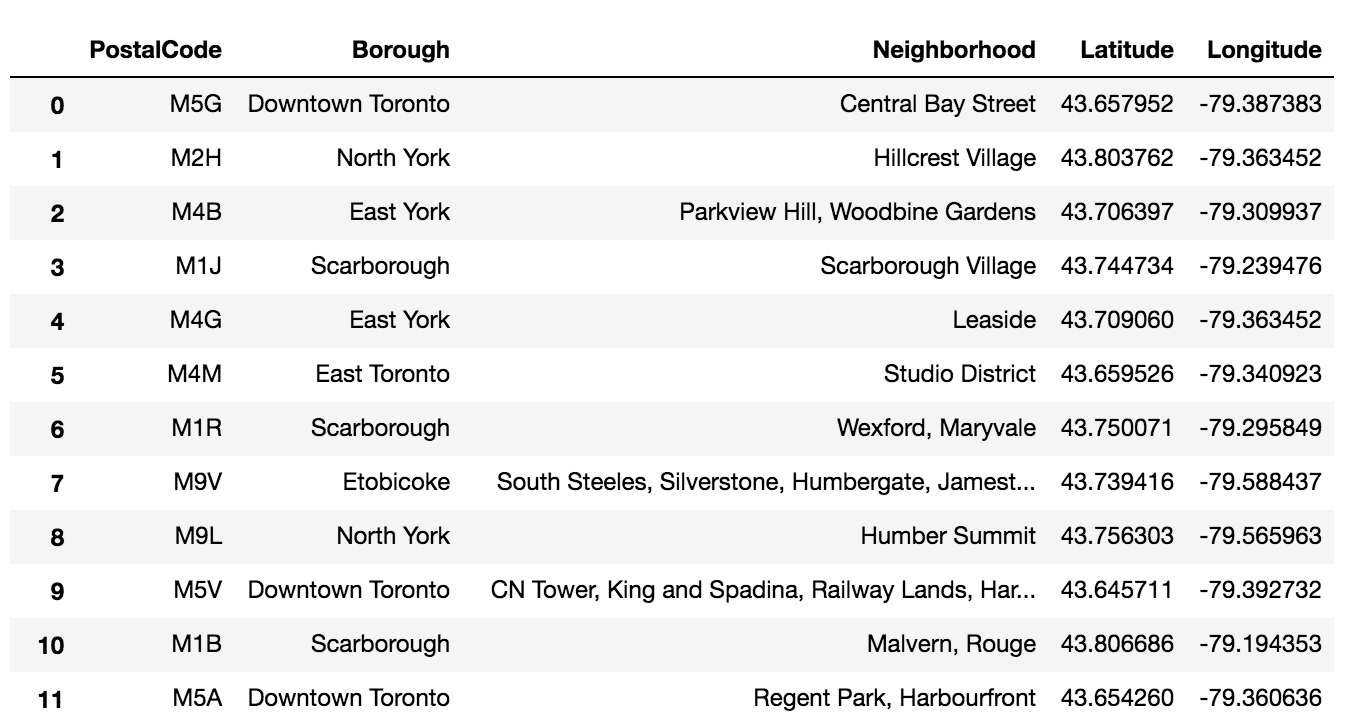

Important Note: There is a limit on how many times you can call geocoder.google function. It is 2500 times per day. This should be way more than enough for you to get acquainted with the package and to use it to get the geographical coordinates of the neighborhoods in the Toronto.

In [157]:
coordinates_df = pd.read_csv('http://cocl.us/Geospatial_data')

In [158]:
#g = geocoder.google('Mountain View, CA')
#g = geocoder.google('Toronto, ON')
#g = geocoder.google('King City, ON')
#g.latlng

In [159]:
coordinates_df.shape

(103, 3)

In [160]:
coordinates_df.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [161]:
#coordinates_df

In [162]:
coordinates_df.rename(columns={'Postal Code':'Postcode'}, inplace=True)
coordinates_df.head()

,Postcode,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [163]:
merged_dataframe = pd.merge(dfTrt, coordinates_df, how='left', on='Postcode')
merged_dataframe.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [164]:
merged_dataframe.shape

(111, 5)

In [165]:
#merged_dataframe_Toronto = merged_dataframe[merged_dataframe['Borough'].str.contains("Toronto")]
#merged_dataframe_Toronto = merged_dataframe[merged_dataframe['Borough'].str.contains("King")]
merged_dataframe_Toronto = merged_dataframe

In [166]:
merged_dataframe_Toronto = merged_dataframe_Toronto.reset_index()
del merged_dataframe_Toronto['index']
merged_dataframe_Toronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [167]:
merged_dataframe_Toronto.shape

(111, 5)

In [168]:
dfToronto = merged_dataframe_Toronto

dfToronto[dfToronto['Latitude'].isnull()]

,Postcode,Borough,Neighbourhood,Latitude,Longitude
103,L7B,King City,King City,NaN,NaN
104,L4G,Aurora,Aurora,NaN,NaN
105,L3X,Newmarket,Newmarket Southwest,NaN,NaN
106,L3Y,Newmarket,Newmarket Northeast,NaN,NaN
107,L4B,Richmond Hill,Richmond Hill Southeast,NaN,NaN
108,L4C,Richmond Hill,Richmond Hill Southwest,NaN,NaN
109,L4E,Richmond Hill,Richmond Hill North,NaN,NaN
110,L4S,Richmond Hill,Richmond Hill Central,NaN,NaN


In [169]:
#dfToronto[dfToronto['Longitude'].isnull()]

In [170]:
geolocator = Nominatim(user_agent="toronto_explorer")

The following are the results from Nominatim.

In [171]:
yr = 'York Region'
location = geolocator.geocode(yr + ', ON')
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of "{}" are {}, {}.'.format(yr, latitude, longitude))

The geograpical coordinate of "York Region" are 44.0007518, -79.4372217.


In [172]:
dfNan = dfToronto[dfToronto['Longitude'].isnull()]
for lat, lng, postalcode, borough, neighborhood in zip(dfNan['Latitude'], dfNan['Longitude'], dfNan['Postcode'], dfNan['Borough'], dfNan['Neighbourhood']):
    location = geolocator.geocode(neighborhood + ', ON')
    latitude = location.latitude
    longitude = location.longitude
    print('The geograpical coordinate of "{}" are {}, {}.'.format(neighborhood, latitude, longitude))

The geograpical coordinate of "King City" are 43.9201118, -79.5270426.
The geograpical coordinate of "Aurora" are 43.99973, -79.467545.
The geograpical coordinate of "Newmarket Southwest" are 44.056258, -79.461708.
The geograpical coordinate of "Newmarket Northeast" are 44.056258, -79.461708.
The geograpical coordinate of "Richmond Hill Southeast" are 43.880078, -79.439392.
The geograpical coordinate of "Richmond Hill Southwest" are 43.880078, -79.439392.
The geograpical coordinate of "Richmond Hill North" are 41.033776, -73.864357.
The geograpical coordinate of "Richmond Hill Central" are 43.880078, -79.439392.


Based on Google,
* King City - 43.9287,-79.5281 : 43.9287° N, 79.5281° W
* Aurora - 44.0065,-79.4504 : 44.0065° N, 79.4504° W
* Newmarket Southwest - 44.0464,-79.4874 : Latitude of city of Newmarket Southwest is 44.0464 and longitude of city of Newmarket Southwest is -79.4874.
* Newmarket Northeast - 44.059189,-79.461258 : The latitude of Newmarket, ON, Canada is 44.059189, and the longitude is -79.461258.
* Richmond Hill Southeast - 43.887501,-79.428406 : The latitude of Richmond Hill, Ontario, Canada is 43.887501, and the longitude is -79.428406.
* Richmond Hill Southwest - 43.8759,-79.4381 : Latitude of city of Richmond Hill Southwest is 43.8759 and longitude of city of Richmond Hill Southwest is -79.4381.
* Richmond Hill North - 43.8980,-79.4288 : 43.8980° N, 79.4288° W
* Richmond Hill Central - 43.8555,-79.4300 : 43.8555° N, 79.4300° W

Use google data to update the missing coordinates.

In [173]:
#dfToronto.loc[dfToronto['Neighbourhood']=='King City']
##Postcode	Borough	Neighbourhood	Latitude	Longitude
##103	L7B	King City	King City	NaN	NaN

#dfToronto[dfToronto['Neighbourhood']=='King City']
##Postcode	Borough	Neighbourhood	Latitude	Longitude
##103	L7B	King City	King City	NaN	NaN

dfToronto.loc[dfToronto['Neighbourhood']=='King City', ['Latitude', 'Longitude']] = [43.9287,-79.5281]
dfToronto.loc[dfToronto['Neighbourhood']=='Aurora', ['Latitude', 'Longitude']] = [44.0065,-79.4504]
dfToronto.loc[dfToronto['Neighbourhood']=='Newmarket Southwest', ['Latitude', 'Longitude']] = [44.0464,-79.4874]
dfToronto.loc[dfToronto['Neighbourhood']=='Newmarket Northeast', ['Latitude', 'Longitude']] = [44.059189,-79.461258]
dfToronto.loc[dfToronto['Neighbourhood']=='Richmond Hill Southeast', ['Latitude', 'Longitude']] = [43.887501,-79.428406]
dfToronto.loc[dfToronto['Neighbourhood']=='Richmond Hill Southwest', ['Latitude', 'Longitude']] = [43.8759,-79.4381]
dfToronto.loc[dfToronto['Neighbourhood']=='Richmond Hill North', ['Latitude', 'Longitude']] = [43.8980,-79.4288]
dfToronto.loc[dfToronto['Neighbourhood']=='Richmond Hill Central', ['Latitude', 'Longitude']] = [43.8555,-79.4300]

In [174]:
#dfToronto[dfToronto['Neighbourhood']=='King City']

In [175]:
dfToronto

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


In [176]:
dfToronto.shape

(111, 5)

In [177]:
# To avoid this error:
#    ValueError: Location values cannot contain NaNs, got: [nan, nan]
dfToronto = dfToronto.dropna(subset=['Latitude'])
dfToronto = dfToronto.dropna(subset=['Longitude'])
dfToronto.shape

(111, 5)

In [178]:
dfToronto.head()

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [179]:
dfToronto

,Postcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848


Once you are able to create the above dataframe, submit a link to the new Notebook on your Github repository. (2 marks)

Part 2 done.

### Part 3

Explore and cluster the neighborhoods in Toronto.

* The geograpical coordinate of Toronto are 43.653963, -79.387207.
* The geograpical coordinate of King City are 43.9201118, -79.5270426.

In [180]:
#address = 'Toronto, ON'
#address = 'King City, ON'
address = yr + ', ON'

In [181]:
geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of "{}" are {}, {}.'.format(address, latitude, longitude))

The geograpical coordinate of "York Region, ON" are 44.0007518, -79.4372217.


In [182]:
# set the map size
#f = folium.Figure(width=500, height=300)

#class folium.folium.Map(location=None, width='100%', height='100%', left='0%', top='0%', position='relative', tiles='OpenStreetMap', attr=None, min_zoom=0, max_zoom=18, zoom_start=10, min_lat=-90, max_lat=90, min_lon=-180, max_lon=180, max_bounds=False, crs='EPSG3857', control_scale=False, prefer_canvas=False, no_touch=False, disable_3d=False, png_enabled=False, zoom_control=True, **kwargs)
map_toronto = folium.Map(location=[latitude, longitude]
                         , width='70%', height='70%'
                         , left='0%', top='0%', zoom_start=10)
map_toronto

In [183]:
map_toronto = folium.Map(location=[latitude, longitude]
                         , width='70%', height='70%'
                         , left='0%', top='0%', zoom_start=10)

for lat, lng, postalcode, borough, neighborhood in zip(dfToronto['Latitude'], dfToronto['Longitude'], dfToronto['Postcode'], dfToronto['Borough'], dfToronto['Neighbourhood']):
    label = '{}, {}, {}'.format(postalcode, borough, neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

Part 3 done.

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

## Explore and Segment Toronto

### Define Foursquare Credentials and Version

In [184]:
CLIENT_ID = 'HE3SHWCSMYZD3EKTPG3FTTJYGXT2LOUVCBRATWGAWTILN1JW' # Foursquare CLIENT ID
CLIENT_SECRET = 'GQL1NA5BV21TRW12EMVSP52WSZEFUY1TL2K1MN0BGAFZCRX1' # Foursquare CLIENT Secret
VERSION = '20200213' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: HE3SHWCSMYZD3EKTPG3FTTJYGXT2LOUVCBRATWGAWTILN1JW
CLIENT_SECRET:GQL1NA5BV21TRW12EMVSP52WSZEFUY1TL2K1MN0BGAFZCRX1


### Let's explore the neighborhood "M5X - First Canadian Place,Underground city" in our dataframe

In [185]:
#dfToronto
dfToronto[dfToronto['Postcode'] == 'M5X']

,Postcode,Borough,Neighbourhood,Latitude,Longitude
70,M5X,Downtown Toronto,"First Canadian Place,Underground city",43.648429,-79.38228


Get the neighborhood's latitude and longitude values.

In [186]:
n = dfToronto.loc[dfToronto['Postcode'] == 'M5X'].index.item()

neighborhood_latitude = dfToronto.loc[n, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = dfToronto.loc[n, 'Longitude'] # neighborhood longitude value

neighborhood_name = dfToronto.loc[n, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of "{}" are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of "First Canadian Place,Underground city" are 43.6484292, -79.3822802.


### Now, let's get the top 100 venues that are in M5X within a radius of 500 meters

First, let's create the GET request URL. Name your URL url.

In [187]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=HE3SHWCSMYZD3EKTPG3FTTJYGXT2LOUVCBRATWGAWTILN1JW&client_secret=GQL1NA5BV21TRW12EMVSP52WSZEFUY1TL2K1MN0BGAFZCRX1&v=20200213&ll=43.6484292,-79.3822802&radius=500&limit=100'

Send the GET request and examine the resutls.

In [188]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e461709bae9a2001bccb49b'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Financial District',
  'headerFullLocation': 'Financial District, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 172,
  'suggestedBounds': {'ne': {'lat': 43.652929204500005,
    'lng': -79.37607280281344},
   'sw': {'lat': 43.6439291955, 'lng': -79.38848759718655}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '501ae947e4b0d11883b910a7',
       'name': 'Equinox Bay Street',
       'location': {'address': '199 Bay St',
        'crossStreet': 'at Commerce Court West, PATH Level',
        'lat': 43.64809974034856,
        'lng': -79.37998869411

All the information is in the items key. 

Before we proceed, we need to define the get_category_type function.

In [189]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a dataframe.

In [190]:
venues = results['response']['groups'][0]['items']
venues

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '501ae947e4b0d11883b910a7',
   'name': 'Equinox Bay Street',
   'location': {'address': '199 Bay St',
    'crossStreet': 'at Commerce Court West, PATH Level',
    'lat': 43.64809974034856,
    'lng': -79.37998869411526,
    'labeledLatLngs': [{'label': 'display',
      'lat': 43.64809974034856,
      'lng': -79.37998869411526}],
    'distance': 188,
    'postalCode': 'M5L 1L5',
    'cc': 'CA',
    'city': 'Toronto',
    'state': 'ON',
    'country': 'Canada',
    'formattedAddress': ['199 Bay St (at Commerce Court West, PATH Level)',
     'Toronto ON M5L 1L5',
     'Canada']},
   'categories': [{'id': '4bf58dd8d48988d176941735',
     'name': 'Gym',
     'pluralName': 'Gyms',
     'shortName': 'Gym',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/building/gym_',
      'suffix': '.png'},
     'primary': True

In [191]:
nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.crossStreet,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.neighborhood,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups,venue.venuePage.id
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-501ae947e4b0d11883b910a7-0,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",501ae947e4b0d11883b910a7,199 Bay St,CA,Toronto,Canada,"at Commerce Court West, PATH Level",188,"[199 Bay St (at Commerce Court West, PATH Leve...","[{'label': 'display', 'lat': 43.64809974034856...",43.648100,-79.379989,NaN,M5L 1L5,ON,Equinox Bay Street,0,[],NaN
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-59cd51c71b0ea516e9e7b3aa-1,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",59cd51c71b0ea516e9e7b3aa,100 King St W,CA,Toronto,Canada,Bay St,117,"[100 King St W (Bay St), Toronto ON M5X, Canada]","[{'label': 'display', 'lat': 43.64883539124589...",43.648835,-79.380936,NaN,M5X,ON,Pilot Coffee Roasters,0,[],NaN
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-55fc571f498ec35023360858-2,"[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",55fc571f498ec35023360858,77 Adelaide St W,CA,Toronto,Canada,btwn Bay & York St,134,"[77 Adelaide St W (btwn Bay & York St), Toront...","[{'label': 'display', 'lat': 43.6495520142626,...",43.649552,-79.381671,NaN,M5X 1C1,ON,Cactus Club Cafe,0,[],NaN
3,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-559a8f5a498e31f945041245-3,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",559a8f5a498e31f945041245,100 King St W,CA,Toronto,Canada,btwn Bay & York st,13,"[100 King St W (btwn Bay & York st), Toronto O...","[{'label': 'display', 'lat': 43.64830873804684...",43.648309,-79.382253,NaN,M5X 1C1,ON,Maman,0,[],NaN
4,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ad4c05df964a52059f620e3-4,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",4ad4c05df964a52059f620e3,66 Wellington St West,CA,Toronto,Canada,at Bay Street,133,"[66 Wellington St West (at Bay Street), Toront...","[{'label': 'display', 'lat': 43.64745206618347...",43.647452,-79.381320,NaN,M5K 1H6,ON,Canoe,0,[],40552945
5,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ad69511f964a520e40721e3-5,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",4ad69511f964a520e40721e3,165 York St,CA,Toronto,Canada,btwn Richmond St. & Adelaide St.,228,[165 York St (btwn Richmond St. & Adelaide St....,"[{'label': 'display', 'lat': 43.64993725298525...",43.649937,-79.384196,NaN,M5H 3R8,ON,The Keg Steakhouse + Bar,0,[],NaN
6,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4bd8cde92e6f0f47dcb20808-6,"[{'id': '4bf58dd8d48988d1cc941735', 'name': 'S...",4bd8cde92e6f0f47dcb20808,120 Adelaide St. W,CA,Toronto,Canada,at York St,130,"[120 Adelaide St. W (at York St), Toronto ON M...","[{'label': 'display', 'lat': 43.64950475647694...",43.649505,-79.382919,NaN,M5H 1T1,ON,Hy's Steakhouse,0,[],NaN
7,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4ea43642be7ba4918efc5afa-7,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",4ea43642be7ba4918efc5afa,1 First Canadian Place,CA,Toronto,Canada,NaN,98,"[1 First Canadian Place, Toronto ON M5X 1C8, C...","[{'label': 'display', 'lat': 43.64927944291712...",43.649279,-79.381921,NaN,M5X 1C8,ON,Adelaide Club Toronto,0,[],NaN
8,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4fccaa8fe4b05a98df3d9417-8,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",4fccaa8fe4b05a98df3d9417,150 King St. W,CA,Toronto,Canada,in the PATH,176,"[150 King St. W (in the PATH), Toronto ON M5H ...","[{'label': 'display', 'lat': 43.64788137014028...",43.647881,-79.384332,NaN,M5H 4B6,ON,Sam James Coffee Bar (SJCB),0,[],NaN
9,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-5462ac56498e128ccafe

In [192]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Equinox Bay Street,"[{'id': '4bf58dd8d48988d176941735', 'name': 'G...",43.648100,-79.379989
1,Pilot Coffee Roasters,"[{'id': '4bf58dd8d48988d1e0931735', 'name': 'C...",43.648835,-79.380936
2,Cactus Club Cafe,"[{'id': '4bf58dd8d48988d14e941735', 'name': 'A...",43.649552,-79.381671
3,Maman,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",43.648309,-79.382253
4,Canoe,"[{'id': '4bf58dd8d48988d1c4941735', 'name': 'R...",43.647452,-79.381320


In [193]:
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Equinox Bay Street,Gym,43.648100,-79.379989
1,Pilot Coffee Roasters,Coffee Shop,43.648835,-79.380936
2,Cactus Club Cafe,American Restaurant,43.649552,-79.381671
3,Maman,Café,43.648309,-79.382253
4,Canoe,Restaurant,43.647452,-79.381320


In [194]:
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()
#nearby_venues

,name,categories,lat,lng
0,Equinox Bay Street,Gym,43.648100,-79.379989
1,Pilot Coffee Roasters,Coffee Shop,43.648835,-79.380936
2,Cactus Club Cafe,American Restaurant,43.649552,-79.381671
3,Maman,Café,43.648309,-79.382253
4,Canoe,Restaurant,43.647452,-79.381320


And how many venues were returned by Foursquare?

In [195]:
print('{} venues were returned by Foursquare for "M5X".'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare for "M5X".


### M5X is so popular. Let's explore another neighborhood "M7Y - Business Reply Mail Processing Centre 969 Eastern".

Let's explore the neighborhood "M7Y - Business Reply Mail Processing Centre 969 Eastern" in our dataframe.

In [196]:
#dfToronto
dfToronto[dfToronto['Postcode'] == 'M7Y']

,Postcode,Borough,Neighbourhood,Latitude,Longitude
87,M7Y,East Toronto,Business Reply Mail Processing Centre 969 Eastern,43.662744,-79.321558


Get the neighborhood's latitude and longitude values.

In [197]:
n = dfToronto.loc[dfToronto['Postcode'] == 'M7Y'].index.item()

neighborhood_latitude = dfToronto.loc[n, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = dfToronto.loc[n, 'Longitude'] # neighborhood longitude value

neighborhood_name = dfToronto.loc[n, 'Neighbourhood'] # neighborhood name

print('Latitude and longitude values of "{}" are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of "Business Reply Mail Processing Centre 969 Eastern" are 43.6627439, -79.321558.


### Now, let's get the top 100 venues that are in M7Y within a radius of 500 meters

First, let's create the GET request URL. Name your URL url.

In [198]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=HE3SHWCSMYZD3EKTPG3FTTJYGXT2LOUVCBRATWGAWTILN1JW&client_secret=GQL1NA5BV21TRW12EMVSP52WSZEFUY1TL2K1MN0BGAFZCRX1&v=20200213&ll=43.6627439,-79.321558&radius=500&limit=100'

Send the GET request and examine the resutls.

In [199]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e46180ab57e8800216b90ba'},
 'response': {'headerLocation': 'Leslieville',
  'headerFullLocation': 'Leslieville, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 17,
  'suggestedBounds': {'ne': {'lat': 43.667243904500005,
    'lng': -79.31534912291306},
   'sw': {'lat': 43.6582438955, 'lng': -79.32776687708693}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '58d4650e2f91cb5ccec03447',
       'name': 'Rorschach Brewing Co.',
       'location': {'address': '1001 Eastern Ave',
        'crossStreet': 'Woodfield Rd',
        'lat': 43.6634831695922,
        'lng': -79.31982368639481,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.6634831695922,
          'lng': -79.31982368639481}],
        

All the information is in the items key. Now we are ready to clean the json and structure it into a dataframe.

In [200]:
venues = results['response']['groups'][0]['items']
venues

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '58d4650e2f91cb5ccec03447',
   'name': 'Rorschach Brewing Co.',
   'location': {'address': '1001 Eastern Ave',
    'crossStreet': 'Woodfield Rd',
    'lat': 43.6634831695922,
    'lng': -79.31982368639481,
    'labeledLatLngs': [{'label': 'display',
      'lat': 43.6634831695922,
      'lng': -79.31982368639481}],
    'distance': 162,
    'postalCode': 'M4L 1A8',
    'cc': 'CA',
    'city': 'Toronto',
    'state': 'ON',
    'country': 'Canada',
    'formattedAddress': ['1001 Eastern Ave (Woodfield Rd)',
     'Toronto ON M4L 1A8',
     'Canada']},
   'categories': [{'id': '50327c8591d4c4b30a586d5d',
     'name': 'Brewery',
     'pluralName': 'Breweries',
     'shortName': 'Brewery',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/brewery_',
      'suffix': '.png'},
     'primary': True}],
   'photos': {

In [201]:
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.head()
#nearby_venues

,name,categories,lat,lng
0,Rorschach Brewing Co.,Brewery,43.663483,-79.319824
1,Leslieville Farmers Market,Farmers Market,43.664901,-79.319784
2,The Sidekick,Comic Shop,43.664484,-79.325162
3,Chino Locos,Burrito Place,43.664653,-79.325584
4,Queen Margherita Pizza,Pizza Place,43.664685,-79.324164


And how many venues were returned by Foursquare?

In [202]:
print('{} venues were returned by Foursquare for "M7Y".'.format(nearby_venues.shape[0]))

17 venues were returned by Foursquare for "M7Y".


### Explore Neighborhoods in Toronto

Let's create a function to repeat the same process to all the neighborhoods.

In [203]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    LIMIT = 200
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Now write the code to run the above function on each neighborhood and create a new dataframe called manhattan_venues.

In [204]:
toronto_venues = getNearbyVenues(names=dfToronto['Neighbourhood'],
                                   latitudes=dfToronto['Latitude'],
                                   longitudes=dfToronto['Longitude']
                                  )

print("All the neighborhoods have been explored.")

All the neighborhoods have been explored.


Let's check the size of the resulting dataframe.

In [205]:
toronto_venues.shape

(2294, 7)

In [206]:
toronto_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Rouge,Malvern",43.806686,-79.194353,Wendy's,43.807448,-79.199056,Fast Food Restaurant
1,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
2,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,Royal Canadian Legion,43.782533,-79.163085,Bar
3,"Guildwood,Morningside,West Hill",43.763573,-79.188711,Swiss Chalet Rotisserie & Grill,43.767697,-79.189914,Pizza Place
4,"Guildwood,Morningside,West Hill",43.763573,-79.188711,G & G Electronics,43.765309,-79.191537,Electronics Store


Let's check how many venues were returned for each neighborhood

In [207]:
#toronto_venues.groupby('Neighborhood').count()

### Venue Categories

Let's find out how many unique categories can be curated from all the returned venues

In [208]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 277 uniques categories.


In [209]:
venue_category = toronto_venues['Venue Category'].unique()
#venue_category = toronto_venues['Venue Category'].drop_duplicates()

In [210]:
df_venue_category = pd.DataFrame(venue_category)
df_venue_category.rename(columns = {0:'Venue Category'}, inplace = True) 
df_venue_category

,Venue Category
0,Fast Food Restaurant
1,Construction & Landscaping
2,Bar
3,Pizza Place
4,Electronics Store
5,Spa
6,Mexican Restaurant
7,Rental Car Location
8,Medical Center
9,Intersection


## Use coarse-grained venue categories

The venue categories are too low level. 

Now I want to change the granularity to more coarse-grained.

The dataframe toronto_venues will be updated.

In [211]:
for i, row in toronto_venues.iterrows():
    cat = toronto_venues.at[i,'Venue Category'].lower()
    #print("{} {} \n\t sandwich : {}".format(i, cat, cat.find(' sandwich')))
    if cat.find('shopping ') >= 0 or cat.find(' shop') >= 0 or cat.find(' mall') >= 0 or cat.find(' store') >= 0 or cat.find(' market') >= 0 or cat.find('supermarket') >= 0 \
        or cat.find('grocery') >= 0 or cat == ' market' :
            toronto_venues.at[i,'Venue Category'] = 'Shop'
    elif cat.find('restaurant') >= 0 or cat.find(' food') >= 0 or cat.find(' bar') >= 0 or cat.find(' breakfast') >= 0 or cat.find('breakfast ') >= 0 or cat.find(' dinner') >= 0 \
        or cat.find('dinner ') >= 0 or cat.find('pizza ') >= 0 or cat.find('noodle ') >= 0 or cat.find('bbq ') >= 0 or cat.find(' bbq') >= 0 \
        or cat.find('café') >= 0 or cat.find(' cafe') >= 0 or cat.find('cafe ') >= 0 or cat.find('coffee ') >= 0 or cat.find(' coffee') >= 0 \
        or cat.find('cafeteria') >= 0 or cat.find('sandwich ') >= 0 or cat.find('salad ') >= 0 or cat.find('bakery') >= 0 \
        or cat.find('tea ') >= 0 or cat.find('taco ') >= 0 or cat.find('steak ') >= 0 or cat.find('steakhouse') >= 0 \
        or cat.find('chicken ') >= 0 or cat.find(' chicken') >= 0 or cat.find(' cheese') >= 0 or cat.find('poutine ') >= 0 \
        or cat.find(' pub') >= 0 or cat.find('deli ') >= 0 or cat == 'bistro' or cat == 'brewery' \
        or cat.find('burger ') >= 0 or cat.find('wings ') >= 0 or cat.find('burrito ') >= 0 or cat.find('boutique') >= 0 \
        or cat.find('gastropub') >= 0 or cat == 'diner' or cat == 'pub' \
        or cat.find('food ') >= 0 :
            toronto_venues.at[i,'Venue Category'] = 'Food'
    elif cat == 'gym' or cat.find('gym ') >= 0 or cat.find(' gym') >= 0 or cat.find(' fitness') >= 0 or cat.find('fitness') >= 0 or cat.find(' sport') >= 0 \
        or cat.find('skating ') >= 0 or cat.find(' skate') >= 0 or cat.find(' swim') >= 0 \
        or cat.find('tennis ') >= 0 or cat.find('golf ') >= 0 or cat.find('soccer ') >= 0 or cat.find(' soccer') >= 0 or cat.find('indoor ') >= 0 or cat == 'pool' \
        or cat.find('baseball') >=0 or cat.find('basketball') >=0 or cat.find('hockey') >=0 or cat.find('curling') >=0 or cat.find('stadium') >=0 :
            toronto_venues.at[i,'Venue Category'] = 'Sport'
    elif cat.find('college ') >= 0 or cat.find(' college') >= 0 :
            toronto_venues.at[i,'Venue Category'] = 'College'    
    elif cat.find('movie ') >= 0 or cat.find('theater') >= 0 or cat.find(' club') >= 0 or cat.find('music ') >= 0 or cat.find('opera ') >= 0 \
        or cat.find('poke ') >= 0 or cat.find(' entertainment') >= 0 or cat.find('nightclub') >= 0 :
            toronto_venues.at[i,'Venue Category'] = 'Entertainment'    
    elif cat == 'airport' or cat.find('airport ') >= 0 or cat.find(' airport') >= 0 or cat.find('bus ') >= 0 or cat.find(' station') >= 0 or cat.find('boat ') >= 0 :
            toronto_venues.at[i,'Venue Category'] = 'Transportation'
    elif len(cat) > 0 :
            toronto_venues.at[i,'Venue Category'] = 'Others'

In [212]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 7 uniques categories.


In [213]:
toronto_venues['Venue Category'].unique()

array(['Food', 'Others', 'Shop', 'Sport', 'Transportation',
       'Entertainment', 'College'], dtype=object)

### Analyze Each Neighborhood

In [214]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")
toronto_onehot.head()

,College,Entertainment,Food,Others,Shop,Sport,Transportation
0,0,0,1,0,0,0,0
1,0,0,0,1,0,0,0
2,0,0,0,1,0,0,0
3,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0


In [215]:
# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 
toronto_onehot.head()

,College,Entertainment,Food,Others,Shop,Sport,Transportation,Neighborhood
0,0,0,1,0,0,0,0,"Rouge,Malvern"
1,0,0,0,1,0,0,0,"Highland Creek,Rouge Hill,Port Union"
2,0,0,0,1,0,0,0,"Highland Creek,Rouge Hill,Port Union"
3,0,0,1,0,0,0,0,"Guildwood,Morningside,West Hill"
4,0,0,0,0,1,0,0,"Guildwood,Morningside,West Hill"


In [216]:
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
fixed_columns

['Neighborhood',
 'College',
 'Entertainment',
 'Food',
 'Others',
 'Shop',
 'Sport',
 'Transportation']

In [217]:
toronto_onehot = toronto_onehot[fixed_columns]
toronto_onehot.head()

,Neighborhood,College,Entertainment,Food,Others,Shop,Sport,Transportation
0,"Rouge,Malvern",0,0,1,0,0,0,0
1,"Highland Creek,Rouge Hill,Port Union",0,0,0,1,0,0,0
2,"Highland Creek,Rouge Hill,Port Union",0,0,0,1,0,0,0
3,"Guildwood,Morningside,West Hill",0,0,1,0,0,0,0
4,"Guildwood,Morningside,West Hill",0,0,0,0,1,0,0


In [218]:
toronto_onehot.shape

(2294, 8)

Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [219]:
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped

,Neighborhood,College,Entertainment,Food,Others,Shop,Sport,Transportation
0,"Adelaide,King,Richmond",0.000000,0.030000,0.580000,0.180000,0.180000,0.030000,0.000000
1,Agincourt,0.000000,0.000000,0.500000,0.250000,0.250000,0.000000,0.000000
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",0.000000,0.000000,0.000000,0.666667,0.333333,0.000000,0.000000
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",0.000000,0.000000,0.454545,0.090909,0.454545,0.000000,0.000000
4,"Alderwood,Long Branch",0.000000,0.000000,0.400000,0.200000,0.100000,0.300000,0.000000
5,Aurora,0.000000,0.058824,0.529412,0.117647,0.235294,0.058824,0.000000
6,"Bathurst Manor,Downsview North,Wilson Heights",0.000000,0.000000,0.421053,0.157895,0.368421,0.000000,0.052632
7,Bayview Village,0.000000,0.000000,0.750000,0.250000,0.000000,0.000000,0.000000
8,"Bedford Park,Lawrence Manor East",0.000000,0.000000,0.692308,0.076923,0.230769,0.000000,0.000000
9,Berczy Park,0.000000,0.018182,0.472727,0.181818,0.309091,0.018182,0.000000


Let's confirm the new size

In [220]:
toronto_grouped.shape

(106, 8)

Let's print each neighborhood along with the top 5 most common venues

In [221]:
num_top_venues = 10

for hood in toronto_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide,King,Richmond----
            venue  freq
0            Food  0.58
1          Others  0.18
2            Shop  0.18
3   Entertainment  0.03
4           Sport  0.03
5         College  0.00
6  Transportation  0.00


----Agincourt----
            venue  freq
0            Food  0.50
1          Others  0.25
2            Shop  0.25
3         College  0.00
4   Entertainment  0.00
5           Sport  0.00
6  Transportation  0.00


----Agincourt North,L'Amoreaux East,Milliken,Steeles East----
            venue  freq
0          Others  0.67
1            Shop  0.33
2         College  0.00
3   Entertainment  0.00
4            Food  0.00
5           Sport  0.00
6  Transportation  0.00


----Albion Gardens,Beaumond Heights,Humbergate,Jamestown,Mount Olive,Silverstone,South Steeles,Thistletown----
            venue  freq
0            Food  0.45
1            Shop  0.45
2          Others  0.09
3         College  0.00
4   Entertainment  0.00
5           Sport  0.00
6  Transportation  0.00


--

Let's put that into a dataframe.

First, let's write a function to sort the venues in descending order.

In [222]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [223]:
num_top_venues = 7 #10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,"Adelaide,King,Richmond",Food,Shop,Others,Sport,Entertainment,Transportation,College
1,Agincourt,Food,Shop,Others,Transportation,Sport,Entertainment,College
2,"Agincourt North,L'Amoreaux East,Milliken,Steel...",Others,Shop,Transportation,Sport,Food,Entertainment,College
3,"Albion Gardens,Beaumond Heights,Humbergate,Jam...",Shop,Food,Others,Transportation,Sport,Entertainment,College
4,"Alderwood,Long Branch",Food,Sport,Others,Shop,Transportation,Entertainment,College


## Cluster Neighborhoods Toronto

Run k-means to cluster the neighborhood into 5 clusters.

In [224]:
# set number of clusters
kclusters = 5

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([3, 3, 2, 3, 1, 3, 3, 3, 3, 3], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [225]:
# add clustering labels
if 'Cluster Labels' not in neighborhoods_venues_sorted.columns:
    neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = dfToronto

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')

# check the last columns!
#toronto_merged.head()
toronto_merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,3.0,Food,Transportation,Sport,Shop,Others,Entertainment,College
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,2.0,Others,Transportation,Sport,Shop,Food,Entertainment,College
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,1.0,Others,Food,Shop,Transportation,Sport,Entertainment,College
3,M1G,Scarborough,Woburn,43.770992,-79.216917,4.0,Shop,Food,Transportation,Sport,Others,Entertainment,College
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3.0,Food,Transportation,Sport,Others,Shop,Entertainment,College
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,2.0,Others,Transportation,Sport,Shop,Food,Entertainment,College
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,4.0,Shop,Transportation,Sport,Others,Food,Entertainment,College
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,1.0,Transportation,Others,Food,Sport,Shop,Entertainment,College
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,1.0,Sport,Others,Food,Transportation,Shop,Entertainment,College
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848,0.0,Sport,Food,Entertainment,Transportation,Shop,Others,College


We need to remove NULL records.

In [226]:
#toronto_merged[toronto_merged['Cluster Labels'].isnull()]

In [227]:
toronto_merged = toronto_merged.dropna(subset=['Cluster Labels'])

In [228]:
toronto_merged.shape

(107, 13)

In [229]:
toronto_merged

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353,3.0,Food,Transportation,Sport,Shop,Others,Entertainment,College
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497,2.0,Others,Transportation,Sport,Shop,Food,Entertainment,College
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711,1.0,Others,Food,Shop,Transportation,Sport,Entertainment,College
3,M1G,Scarborough,Woburn,43.770992,-79.216917,4.0,Shop,Food,Transportation,Sport,Others,Entertainment,College
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,3.0,Food,Transportation,Sport,Others,Shop,Entertainment,College
5,M1J,Scarborough,Scarborough Village,43.744734,-79.239476,2.0,Others,Transportation,Sport,Shop,Food,Entertainment,College
6,M1K,Scarborough,"East Birchmount Park,Ionview,Kennedy Park",43.727929,-79.262029,4.0,Shop,Transportation,Sport,Others,Food,Entertainment,College
7,M1L,Scarborough,"Clairlea,Golden Mile,Oakridge",43.711112,-79.284577,1.0,Transportation,Others,Food,Sport,Shop,Entertainment,College
8,M1M,Scarborough,"Cliffcrest,Cliffside,Scarborough Village West",43.716316,-79.239476,1.0,Sport,Others,Food,Transportation,Shop,Entertainment,College
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848,0.0,Sport,Food,Entertainment,Transportation,Shop,Others,College


Finally, let's visualize the resulting clusters

In [230]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=9.5)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    #print("lat, lon, poi, cluster: {}, {}, {}, {}".format(lat, lon, poi, cluster))
    label = folium.Popup("[Cluster {}] {}".format(str(cluster + 1), str(poi)), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1

In [231]:
#toronto_merged.loc[toronto_merged['Cluster Labels'] == 0]
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]]

,Postcode,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
9,M1N,Scarborough,0.0,Sport,Food,Entertainment,Transportation,Shop,Others,College
17,M2H,North York,0.0,Sport,Food,Others,Transportation,Shop,Entertainment,College
26,M3B,North York,0.0,Sport,Food,Transportation,Shop,Others,Entertainment,College
36,M4C,East York,0.0,Sport,Shop,Others,Transportation,Food,Entertainment,College
91,M8Y,Etobicoke,0.0,Sport,Transportation,Shop,Others,Food,Entertainment,College
97,M9M,North York,0.0,Sport,Transportation,Shop,Others,Food,Entertainment,College
105,L3X,Newmarket,0.0,Sport,Food,Shop,Transportation,Others,Entertainment,College
107,L4B,Richmond Hill,0.0,Sport,Transportation,Others,Shop,Food,Entertainment,College


#### Cluster 2

In [232]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]]

,Postcode,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
2,M1E,Scarborough,1.0,Others,Food,Shop,Transportation,Sport,Entertainment,College
7,M1L,Scarborough,1.0,Transportation,Others,Food,Sport,Shop,Entertainment,College
8,M1M,Scarborough,1.0,Sport,Others,Food,Transportation,Shop,Entertainment,College
29,M3J,North York,1.0,Shop,Others,Food,Transportation,Sport,Entertainment,College
32,M3M,North York,1.0,Sport,Others,Food,Transportation,Shop,Entertainment,College
34,M4A,North York,1.0,Food,Sport,Shop,Others,Transportation,Entertainment,College
35,M4B,East York,1.0,Food,Others,Sport,Transportation,Shop,Entertainment,College
37,M4E,East Toronto,1.0,Others,Shop,Food,Transportation,Sport,Entertainment,College
39,M4H,East York,1.0,Food,Shop,Others,Sport,Transportation,Entertainment,College
45,M4P,Central Toronto,1.0,Food,Shop,Others,Sport,Transportation,Entertainment,College


#### Cluster 3

In [233]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]]

,Postcode,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
1,M1C,Scarborough,2.0,Others,Transportation,Sport,Shop,Food,Entertainment,College
5,M1J,Scarborough,2.0,Others,Transportation,Sport,Shop,Food,Entertainment,College
14,M1V,Scarborough,2.0,Others,Shop,Transportation,Sport,Food,Entertainment,College
23,M2P,North York,2.0,Others,Shop,Transportation,Sport,Food,Entertainment,College
30,M3K,North York,2.0,Others,Transportation,Shop,Sport,Food,Entertainment,College
44,M4N,Central Toronto,2.0,Others,Transportation,Sport,Shop,Food,Entertainment,College
48,M4T,Central Toronto,2.0,Others,Transportation,Sport,Shop,Food,Entertainment,College
50,M4W,Downtown Toronto,2.0,Others,Transportation,Sport,Shop,Food,Entertainment,College
73,M6C,York,2.0,Others,Sport,Transportation,Shop,Food,Entertainment,College
74,M6E,York,2.0,Others,Shop,Transportation,Sport,Food,Entertainment,College


#### Cluster 4

In [234]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[0] + [1] + list(range(5, toronto_merged.shape[1]))]]

,Postcode,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
0,M1B,Scarborough,3.0,Food,Transportation,Sport,Shop,Others,Entertainment,College
4,M1H,Scarborough,3.0,Food,Transportation,Sport,Others,Shop,Entertainment,College
10,M1P,Scarborough,3.0,Food,Shop,Transportation,Sport,Others,Entertainment,College
11,M1R,Scarborough,3.0,Food,Shop,Others,Transportation,Sport,Entertainment,College
12,M1S,Scarborough,3.0,Food,Shop,Others,Transportation,Sport,Entertainment,College
13,M1T,Scarborough,3.0,Food,Others,Shop,Transportation,Sport,Entertainment,College
15,M1W,Scarborough,3.0,Food,Shop,Others,Transportation,Sport,Entertainment,College
19,M2K,North York,3.0,Food,Others,Transportation,Sport,Shop,Entertainment,College
20,M2L,North York,3.0,Food,Transportation,Sport,Shop,Others,Entertainment,College
22,M2N,North York,3.0,Food,Shop,Others,Entertainment,Transportation,Sport,College


#### Cluster 5

In [235]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
3,Scarborough,4.0,Shop,Food,Transportation,Sport,Others,Entertainment,College
6,Scarborough,4.0,Shop,Transportation,Sport,Others,Food,Entertainment,College
18,North York,4.0,Shop,Food,Others,Entertainment,Transportation,Sport,College
24,North York,4.0,Shop,Others,Food,Transportation,Sport,Entertainment,College
25,North York,4.0,Shop,Others,Transportation,Sport,Food,Entertainment,College
27,North York,4.0,Shop,Food,Sport,Others,Transportation,Entertainment,College
31,North York,4.0,Shop,Others,Transportation,Sport,Food,Entertainment,College
33,North York,4.0,Shop,Sport,Transportation,Others,Food,Entertainment,College
38,East York,4.0,Shop,Food,Sport,Others,Transportation,Entertainment,College
40,East York,4.0,Shop,Others,Transportation,Sport,Food,Entertainment,College


Any Cluster 1 borough has 'Shop' as the '1st Most Common Venue'?

In [236]:
toronto_merged[(toronto_merged['Cluster Labels'] == 0) & (toronto_merged['1st Most Common Venue'] == 'Shop')]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue


Any Cluster 1 borough has 'Shop' as the '2nd Most Common Venue'?

In [237]:
toronto_merged[(toronto_merged['Cluster Labels'] == 0) & (toronto_merged['2nd Most Common Venue'] == 'Shop')]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
36,M4C,East York,Woodbine Heights,43.695344,-79.318389,0.0,Sport,Shop,Others,Transportation,Food,Entertainment,College


Any Cluster 1 borough has 'Shop' as the '3rd Most Common Venue'?

In [238]:
toronto_merged[(toronto_merged['Cluster Labels'] == 0) & (toronto_merged['3rd Most Common Venue'] == 'Shop')]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
91,M8Y,Etobicoke,"Humber Bay,King's Mill Park,Kingsway Park Sout...",43.636258,-79.498509,0.0,Sport,Transportation,Shop,Others,Food,Entertainment,College
97,M9M,North York,"Emery,Humberlea",43.724766,-79.532242,0.0,Sport,Transportation,Shop,Others,Food,Entertainment,College
105,L3X,Newmarket,Newmarket Southwest,44.046400,-79.487400,0.0,Sport,Food,Shop,Transportation,Others,Entertainment,College


Any Cluster 1 borough has 'Shop' as the '4th Most Common Venue'?

In [239]:
toronto_merged[(toronto_merged['Cluster Labels'] == 0) & (toronto_merged['4th Most Common Venue'] == 'Shop')]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
26,M3B,North York,Don Mills North,43.745906,-79.352188,0.0,Sport,Food,Transportation,Shop,Others,Entertainment,College
107,L4B,Richmond Hill,Richmond Hill Southeast,43.887501,-79.428406,0.0,Sport,Transportation,Others,Shop,Food,Entertainment,College


Any Cluster 1 borough has 'Shop' as the '5th Most Common Venue'?

In [240]:
toronto_merged[(toronto_merged['Cluster Labels'] == 0) & (toronto_merged['5th Most Common Venue'] == 'Shop')]

,Postcode,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue
9,M1N,Scarborough,"Birch Cliff,Cliffside West",43.692657,-79.264848,0.0,Sport,Food,Entertainment,Transportation,Shop,Others,College
17,M2H,North York,Hillcrest Village,43.803762,-79.363452,0.0,Sport,Food,Others,Transportation,Shop,Entertainment,College


## Make the Decision

Based on above analysis, we need to choose a borough in Cluster 1 who has 'Shop' as the '3rd Most Common Venue'.

We found there are 3 boroughs meet these 2 requirements -
* M8Y
* M9M
* L3X

In [241]:
dfToronto[(dfToronto['Postcode'] == 'M8Y') | (dfToronto['Postcode'] == 'M9M') | (dfToronto['Postcode'] == 'L3X')]

,Postcode,Borough,Neighbourhood,Latitude,Longitude
91,M8Y,Etobicoke,"Humber Bay,King's Mill Park,Kingsway Park Sout...",43.636258,-79.498509
97,M9M,North York,"Emery,Humberlea",43.724766,-79.532242
105,L3X,Newmarket,Newmarket Southwest,44.046400,-79.487400


Here is the map for M8Y -

In [251]:
postcode = 'M8Y'

lat = dfToronto[dfToronto['Postcode'] == postcode]['Latitude']
lon = dfToronto[dfToronto['Postcode'] == postcode]['Longitude']
print('The geograpical coordinate of {} are {}, {}.'.format(postcode, float(lat), float(lon)))

map_postcode = folium.Map(location=[float(lat), float(lon)], zoom_start=14)
map_postcode

The geograpical coordinate of M8Y are 43.6362579, -79.49850909999999.


Here is the map for M9M -

In [252]:
postcode = 'M9M'

lat = dfToronto[dfToronto['Postcode'] == postcode]['Latitude']
lon = dfToronto[dfToronto['Postcode'] == postcode]['Longitude']
print('The geograpical coordinate of {} are {}, {}.'.format(postcode, float(lat), float(lon)))

map_postcode = folium.Map(location=[float(lat), float(lon)], zoom_start=14)
map_postcode

The geograpical coordinate of M9M are 43.7247659, -79.53224240000002.


Here is the map for L3X -

In [253]:
postcode = 'L3X'

lat = dfToronto[dfToronto['Postcode'] == postcode]['Latitude']
lon = dfToronto[dfToronto['Postcode'] == postcode]['Longitude']
print('The geograpical coordinate of {} are {}, {}.'.format(postcode, float(lat), float(lon)))

map_postcode = folium.Map(location=[float(lat), float(lon)], zoom_start=14)
map_postcode

The geograpical coordinate of L3X are 44.0464, -79.4874.


Considering L3X has more potential and other factors, I finally chose "L3X - Newmarket Southwest" as the location of my new store.

Thanks for Data Science!